<a href="https://colab.research.google.com/github/amalvarezme/AprendizajeMaquina/blob/main/6_ReinforcementLearning/3_Colab_markovdecisionprocess_qlearning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Procesos de Decisión de Markov

-- **Markov chains**: proceso estocástico sin memoría, con número finito de estados que evoluciona de forma aleatoria de un estado a otro.

![MarkovChains](https://i.stack.imgur.com/ScogN.gif)

-- La probabilidad de pasar de un estado $s$ a $s'$ es fija, y depende solo del par ($s$,$s'$), no de estados pasados.

-- **Markov Decision Processes (Procesos de decisión de Markov) - MDP**: En cada estado el agente puede escoger una de varias acciones y las probabilidades de transición dependen de la acción escogida.



-- Los MDP también pueden incluir transición de estados que involucren rewards (positivos o negativos).

-- Se busca que un agente en un MDP máximice el reward en el tiempo con base a una policy.


![MDPRL](https://www.researchgate.net/profile/Elliot-Ludvig/publication/269517554/figure/fig3/AS:295080465321987@1447364073879/Reinforcement-Learning-and-Markov-Decision-Processes-A-The-world-according-to.png)


In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
#for dirname, _, filenames in os.walk('/kaggle/input'):
#    for filename in filenames:
#        print(os.path.join(dirname, filename))

import sys
import sklearn


!pip install gymnasium[classic_control]  #install gymnasium and virtual display
!pip install pyvirtualdisplay
import gym
import pyvirtualdisplay
import tensorflow as tf
from tensorflow import keras

# to make this notebook's output stable across runs
np.random.seed(42)
tf.random.set_seed(42)

# To plot pretty figures
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# To get smooth animations
import matplotlib.animation as animation
mpl.rc('animation', html='jshtml')

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "rl"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)


#display = pyvirtualdisplay.Display(visible=0, size=(1400, 900)).start()
#display

- Simulación de una secuencia de longitud fija dado una matriz de transición desde una [distribución multinomial](https://en.wikipedia.org/wiki/Multinomial_distribution)

In [ ]:
def MC_evolve(A,T=10):
  #T number of step to evolve
  M = A.shape[0] #Number of states
  s = np.argmax(np.random.multinomial(1, np.ones(M)/M))
  seq = [s]
  for t in range(T-1):
    s = np.argmax(np.random.multinomial(1, A[s,:]))
    seq.append(s)

  return seq

![MDP](https://github.com/amalvarezme/AprendizajeMaquina/blob/main/6_ReinforcementLearning/mdp.jpeg?raw=1)

In [ ]:
A = np.array([[0.7 ,0.2 ,0   ,0.1],
              [0   ,0   ,0.9 ,0.1],
              [0   ,1.0 ,0   ,0],
              [0   ,0   ,0   ,1]])

print('State transition matrix')
print(A)

print('MC sequence:')
MC_evolve(A,5)

State transition matrix
[[0.7 0.2 0.  0.1]
 [0.  0.  0.9 0.1]
 [0.  1.  0.  0. ]
 [0.  0.  0.  1. ]]
MC sequence:


[1, 2, 1, 2, 1]

-- Simulación de una secuencia estado-acción de longitud finita dado un proceso de decisión de Markov, asumiendo que todas las acciones son igualmente probables (no hay sesgo de estrategia - policy).

In [ ]:
def MDP_evolve(MDP,T=10):
  #T number of step to evolve
  N = len(MDP['A']) #Number of states

  #Initial state:
  s = np.argmax(np.random.multinomial(1, np.ones(N)/N))

  seq = []

  for t in range(T-1):
    #Choose an action:
    a_s = MDP['a'][s] #Possible actions
    Na = len(a_s)     #Number of possible actions
    index = np.argmax(np.random.multinomial(1, np.ones(Na)/Na)) #All actions are equally probable
    a = MDP['a'][s][index] #Chosen action

    #Sample the next state:
    s_next = np.argmax(np.random.multinomial(1, MDP['A'][s][a]))

    #Claim the reward:
    reward = MDP['R'][s][a][s_next]

    #Append to the list:
    seq.append([s,a,reward])

    s = s_next
    #print(s_next)

  return np.array(seq)

## Ejemplo simulación MDP

-- Se definen algunas probabilidades de transición, rewards y acciones.

![mdprl](https://github.com/amalvarezme/AprendizajeMaquina/blob/main/6_ReinforcementLearning/mdprl.jpeg?raw=1)


-- **Por ejemplo**:
- En el estado s0, si la acción escogida es a0 con probabilidadis 0.7 se ira a estado s0 con reward +10.
- Con probabilidad 0.3 se ira a estado s1 sin reward, y nunca se alcanzará el estado s2
- Probabilidades de transición:  `[0.7, 0.3, 0.0]`.
- Rewards `[+10, 0, 0]`

Transition probabilities: 0.8
Rewards: 10
Possible actions:
State 0: [0, 1, 2]
State 1: [0, 2]
State 2: [1]


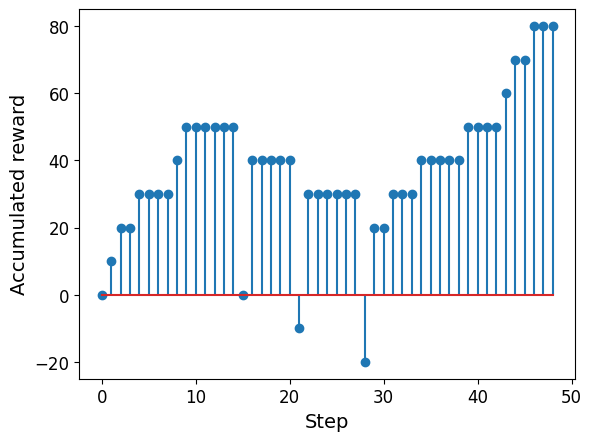

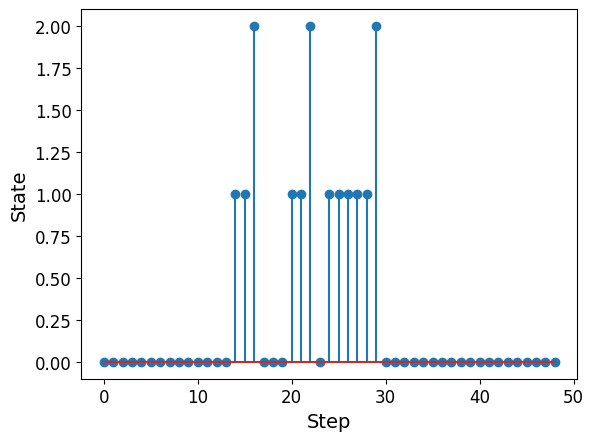

[0 2 0]


In [ ]:
np.random.seed(123)
transition_probabilities = [ # shape=[s, a, s']
[[0.7, 0.3, 0.0], [1.0, 0.0, 0.0], [0.8, 0.2, 0.0]],
[[0.0, 1.0, 0.0], None, [0.0, 0.0, 1.0]],
[None, [0.8, 0.1, 0.1], None]]

rewards = [ # shape=[s, a, s']
[[+10, 0, 0], [0, 0, 0], [0, 0, 0]],
[[0, 0, 0], [0, 0, 0], [0, 0, -50]],
[[0, 0, 0], [+40, 0, 0], [0, 0, 0]]]

possible_actions = [[0, 1, 2], [0, 2], [1]]

MDP = {'A':transition_probabilities,'R':rewards,'a':possible_actions}

print('Transition probabilities:',MDP['A'][0][2][0])
print('Rewards:',MDP['R'][0][0][0])
print('Possible actions:')
for state,actions in enumerate(MDP['a']):
  print('State {}:'.format(state),actions)


seq = MDP_evolve(MDP,T=50)

plt.stem(np.cumsum(seq[:,2]))
plt.xlabel('Step')
plt.ylabel('Accumulated reward')
plt.show()

plt.stem(seq[:,0])
plt.xlabel('Step')
plt.ylabel('State')
plt.show()

print(seq[0])

# Algoritmo Q-Value iterativo:

-- **Ecuación de Bellman**: en un MDP algunos estados incluyen acciones para las que no es claro que acción generará mejores rewards a lo largo del tiempo.

-- Bellman encontró una estimación del valor óptimo de estado para cualquier $s$, como la suma de todos los discounted rewards futuros que el agente espera en promedio después de alcanzar un estado $s'$, asumiendo que actua de forma óptima.

-- Si el agente actua de forma óptima, la Bellman Optimality equation aplica según:

$$V^*(s)= \max_a \sum_s T(s,a,s')\left(R(s,a,s')+\gamma V^*(s')\right); \quad \forall s$$

- $V^*(s):$ Valor óptimo estimado para el estado $s$.

- $T(s,a,s')$: probabilidad de transición del estado $s$ al estado $s'$ mediante la acción $a$.

- $R(s,a,s')$: reward del agente al pasar del estado $s$ al $s'$ mediante la acción $a$.

- $\gamma:$ factor de descuento.

-- **Algoritmo Value iteration**:

$$ V_{k+1}(s) \leftarrow \max_a  \sum_{s'} T(s,a,s')\left(R(s,a,s')+\gamma V_k^*(s')\right); \quad \forall s$$

 - $V_k(s):$ Valor óptimo estimado para el estado $s$ en la iteración $k$.
 - Conocer el valor óptimo del estado es útil para evaluar la policy, aunque NO provee la policy óptima del agente.
 -Bellman extendió el mismo concepto para estimar los valores óptimos de estado-acción (Q-Values).

-- **Algoritmo Q-Value iteration**

 - $Q^*(s,a):$ par Q-Value de estado-acción como la suma de rewards futuros descontados que el agente puede esperar en promedio después que alcanza el estado $s$ y escoge la acción $a$ pero antes de ver la salida de dicha acción, asumiendo que se desenvuelve de manera óptima después de la misma.


$$ Q_{k+1}(s,a) \leftarrow \sum_{s'} T(s,a,s')\left(R(s,a,s')+\gamma \max_{a'}Q_k(s',a')\right); \quad \forall (s',a)$$

- Los valores Q-value se inicializan en cero.

- Después de obtener los Q-Values óptimos, se definie la policy óptima como:

$$\pi^*(s)=\arg\max_a Q^*(s,a)$$



In [ ]:
#Ejemplo de simulación

Q_values = np.full((3, 3), -np.inf) # -np.inf para acciones no posibles
for state, actions in enumerate(possible_actions): #inicializar en 0
    Q_values[state, actions] = 0.0  #

gamma = 0.90  # discount factor

history1 = []
for iteration in range(50):
    Q_prev = Q_values.copy()
    history1.append(Q_prev)
    for s in range(3):
        for a in possible_actions[s]:
            Q_values[s, a] = np.sum([
                    transition_probabilities[s][a][sp]
                    * (rewards[s][a][sp] + gamma * np.max(Q_prev[sp]))
                for sp in range(3)])

history1 = np.array(history1)

Q_values

array([[18.91891892, 17.02702702, 13.62162162],
       [ 0.        ,        -inf, -4.87971488],
       [       -inf, 50.13365013,        -inf]])

**Nota**:  Se observa que si el agente se encuentra en $s_0$ y escoge la acción $a_1$, el esperado de descuentos futuros (discounted rewards) es de 17.02 aprox.

In [ ]:
np.argmax(Q_values, axis=1) # max por columnas para encontrar la mejor accion en cada state

array([0, 0, 1])

La policy óptima para este proceso de Markov es (discount factor en 0.9):

- $a_0$ en estado $s_0$
- $a_0$ en estado $s_1$
- $a_1$ en estado $s_2$ (única acción disponible)

Cambiando el discount factor a 0.95:

In [ ]:
Q_values = np.full((3, 3), -np.inf) # -np.inf for impossible actions
for state, actions in enumerate(possible_actions):
    Q_values[state, actions] = 0.0  # for all possible actions

In [ ]:
gamma = 0.95  # the discount factor

for iteration in range(50):
    Q_prev = Q_values.copy()
    for s in range(3):
        for a in possible_actions[s]:
            Q_values[s, a] = np.sum([
                    transition_probabilities[s][a][sp]
                    * (rewards[s][a][sp] + gamma * np.max(Q_prev[sp]))
                for sp in range(3)])

In [ ]:
Q_values

array([[21.73304188, 20.63807938, 16.70138772],
       [ 0.95462106,        -inf,  1.01361207],
       [       -inf, 53.70728682,        -inf]])

In [ ]:
np.argmax(Q_values, axis=1)

array([0, 2, 1])

- Ahora en $s_1$ se escoge acción $a_2$.
- Si el discount factor es más alto, valorará opciones futuras, el agente está dispuesto a pagar más penalidades buscando rewards futuros (más arriesgado!).

# Temporal Difference Learning (Aprendizaje por diferencia temporal)

- En Reinforcement Learning los problemas con acciones discretas se modelan como procesos de decisión de Markov.

- Sin embargo, en general el agente NO tiene idea sobre las probabilidades de transición ($T(s,a,s')$ no se conoce!).

- Tampoco se conocen los rewards que se van obteniendo ($R(s,a,s')$ no se conoce!).

- Se debe experimentar sobre cada estado y cada transición al menos una vez para conocer los rewards, y se debe experimentar múltiples veces dicho proceso para tener un buen estimado de las probabilidades de transición.

- El algoritmo Temporal Difference Learning es similar al Value Iteration, pero se ajusta para cuando el agente solo tiene conocimiento parcial del proceso de decisión de Markov.

- Se asume que el agente conoce solo los posibles estados y acciones.

- El agente usa una `exploration policy`, i.e., policy aleatoria para explorar el proceso de decisión de Markov.

- El TD actualiza el estimado de los valores de estado utilizando las transiciones y rewards que se observan:

$$V_{k+1}(s)\leftarrow (1-\alpha)V_k(s)+\alpha(r +\gamma V_k(s'))$$

$$V_{k+1}(s)\leftarrow V_k(s)+\alpha \delta_k(s,r,s')$$

$\alpha$: learning rate
$r$: reward promedio

$\gamma:$ discount factor

$r+\gamma V_k(s'):$ TD target

$\delta_k(s,r,s')=r+\gamma V_k(s')-V_k(s):$ TD error


# Q-Learning

-- Es una adaptación del Q-Value Iteration para cuando las probabilidades de transición y los rewards no se conocen inicialmente.

-- Se observa al agente jugar, e.g., aleatoriamente, y se mejoran las estimaciones de Q-Value de forma gradual.

-- Una vez se conocen los Q-Value, la policy óptima se escoge desde la acción con Q-Value más alto, i.e., greedy policy.

$$Q(s,a) \leftarrow_\alpha r+\gamma \max_{a'}Q(s',a')$$

Nota: $a \leftarrow_\alpha b$ equivalente a $a_{k+1}\leftarrow (1-\alpha)a_k-\alpha b_k$

-- Para cada par estado-acción (s,a) el algoritmo monitorea el avance del promedio de rewards $r$ que el agente obtuvo hasta dejar el estado $s$ con la acción $a$.

-- Se simulará un agente moviéndose en el escenario, definiendo una función que efectue alguna acción y obtener el nuevo estado y un reward:

In [ ]:
def step(state, action):
    probas = transition_probabilities[state][action]
    next_state = np.random.choice([0, 1, 2], p=probas)
    reward = rewards[state][action][next_state]
    return next_state, reward

-- Se necesita una exploration policy, para visitar cada estado muchas veces.

-- Se empleará una policy aleatoria, dado que el espacio de estados es pequeño.

In [ ]:
def exploration_policy(state):
    return np.random.choice(possible_actions[state])

-- Ahora, se inicializará los Q-Values y se aplicará el Q-Learning algorithm:

In [ ]:
np.random.seed(42)

Q_values = np.full((3, 3), -np.inf)
for state, actions in enumerate(possible_actions):
    Q_values[state][actions] = 0

alpha0 = 0.05 # initial learning rate
decay = 0.005 # learning rate decay
gamma = 0.90 # discount factor
state = 0 # initial state
history2 = []

for iteration in range(10000):
    history2.append(Q_values.copy())
    action = exploration_policy(state)
    next_state, reward = step(state, action)
    next_value = np.max(Q_values[next_state]) # greedy policy at the next step
    alpha = alpha0 / (1 + iteration * decay)
    Q_values[state, action] *= 1 - alpha
    Q_values[state, action] += alpha * (reward + gamma * next_value)
    state = next_state

history2 = np.array(history2)

Q_values

array([[18.77621289, 17.2238872 , 13.74543343],
       [ 0.        ,        -inf, -8.00485647],
       [       -inf, 49.40208921,        -inf]])

In [ ]:
np.argmax(Q_values, axis=1) # optimal action for each state

array([0, 0, 1])

Saving figure q_value_plot


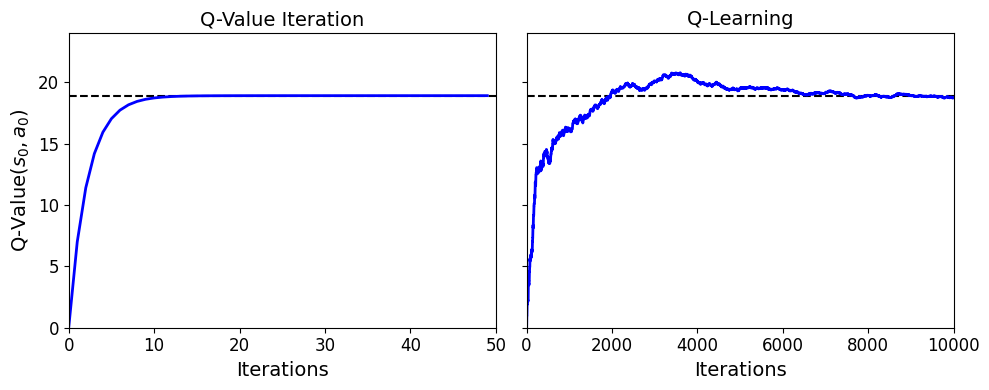

In [ ]:
true_Q_value = history1[-1, 0, 0]

fig, axes = plt.subplots(1, 2, figsize=(10, 4), sharey=True)
axes[0].set_ylabel("Q-Value$(s_0, a_0)$", fontsize=14)
axes[0].set_title("Q-Value Iteration", fontsize=14)
axes[1].set_title("Q-Learning", fontsize=14)
for ax, width, history in zip(axes, (50, 10000), (history1, history2)):
    ax.plot([0, width], [true_Q_value, true_Q_value], "k--")
    ax.plot(np.arange(width), history[:, 0, 0], "b-", linewidth=2)
    ax.set_xlabel("Iterations", fontsize=14)
    ax.axis([0, width, 0, 24])

save_fig("q_value_plot")

-- El algoritmo Q-Learning converge al Q-Value óptimo, pero requiere de muchas iteraciones.

-- Se deben sintonizar varios hyperparámetros!

-- Q-Value iteration converge más rápido.

-- Sin embargo, Q-Learning no conoce las probabilidades de transición ni los rewards, lo que hace más díficil conocer la pocily óptima.

-- Q-Learning se conoce como off-policy dado que la policy ejecutada es no necesariamente la ejecutada-> la policy ejecutada es exploratoria (random), mientras que la entrenada será siempre escogida desde las acciones con los Q-Values más altos.

-- **Q-Learning aprende solo observando un agente actuando aleatoriamente**

-- Imagine aprender a jugar golf con un profesor tipo miquito borracho XD!

# Exploration policies

-- Q-Learning funciona si la exploration policy explora el MDP completamente.

-- Una policy totalmente aleatoria converge eventualmente pero requiere muchas iteraciones.

-- **$\epsilon$-greedy policy**: en cada paso el agente explora de forma aleatoria con probabilidad $\epsilon$, o greedy con probabilidad $1-\epsilon$ (escoger la acción con el Q-value más alto).

-- Se sugiere iniciar con un $\epsilon$ en 1 y se va reduciendo hasta 0.05.

-- **Q-Learning** usando función de exploración:


$$Q(s,a)\leftarrow_\alpha r + \gamma \max_{a'} f\left(Q(s',a'),N(s',a')\right) $$

- $N(s',a'):$ conteo del número de veces que la acción $a'$ fue escogida en estado $s'$
- $f(Q,N):$ es una función de exploración, tal que: $f(Q,N)=Q + \kappa/(1+N),$ siendo $\kappa$ un hiperpárametro de curiosidad.

# Q-Learning aproximado y Deep Q-Learning

-- Q-Learning no es flexible para MDP grandes (NO ESCALABLE).

-- Ejemplo Ms. Pac-Man :
 - 150  galletas (cada una puede estar disponible o no).
 - Posibles estados $2^{150} \approx 10^{45}$
 - Incluya todas las posibles combinaciones de posiciones de Pac-Man, fantasmas, galletas, **los posibles estados son inmanejables!**

-- **No es posible calcular todos los Q-Value**

-- **Solución:** Encontrar una aproximación (Approximate Q-Learning) $Q_\theta(s,a) \approx Q-Value$, con un número manejable de parámetros $\mathbf{\theta}.$

-- **Alternativa 1**: utilizar combinaciones lineales de características predefinidas, e.j., distancia entre Ms. Pac-Man y fantasmas, galletas, etc.

-- **Aleternativa 2**: Utilizar deep learning sin necesidad de imponer características predefinidas ([Playing Atari with Deep Reinforcement Learning-Deep mind en 2013](https://arxiv.org/abs/1312.5602)). [DeepMind website](https://deepmind.google/)

-- Deep learning para estimar Q-Value es llamado **Deep Q-Network--(DQN)**

-- Deep learning para aproximar Q-Learning es llamado **Deep Q-Learning--(DQL)**

-- Partiendo del principio de Bellman, se puede definir el Target Q-Value desde $Q_\theta$ como:

$$Q_{target}(s,a)= r + \gamma \max_{a'} Q_\theta(s',a')$$

$r$: reward

$\gamma$: factor de descuento

-- Con el Q target se puede implementar una estrategia de entrenamiento basada en *gradiente descendiente*.

-- En general se plantea el mse o Huber loss entre el Q-Value estimado y el Q-Value target.


## Implementación DQN:

Dado un estado, se estimará por cada acción, la suma de rewards futuros descontados después de jugar dicha acción (sin conocer su salida):

In [ ]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

env = gym.make("CartPole-v1",render_mode="rgb_array")
input_shape = [4] # == env.observation_space.shape
n_outputs = 2 # == env.action_space.n

model = keras.models.Sequential([
    keras.layers.Dense(32, activation="elu", input_shape=input_shape),
    keras.layers.Dense(32, activation="elu"),
    keras.layers.Dense(n_outputs)
])

/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(


-- Para escoger una acción  con DQN, se escoge la acción con el Q-value más grande.

-- Sin embargo, para explorar, se selecciona una acción de forma aleatoria con probabilidad `epsilon`.

In [ ]:
def epsilon_greedy_policy(state, epsilon=0):
    if np.random.rand() < epsilon:
        return np.random.randint(n_outputs)
    else:
        Q_values = model.predict(state[np.newaxis])
        return np.argmax(Q_values[0])

-- Se requiere un replay memory.

-- El replay memory contiene las experiencias del agente en tuplas: `(obs, action, reward, next_obs, done)`.

-- Se usará la `deque` class

In [ ]:
from collections import deque

replay_memory = deque(maxlen=2000)

-- Se crea una función  para muestrear experiencias desde el replay memory.

-- Retornará 5 NumPy arrays: `[obs, actions, rewards, next_obs, dones]`.

In [ ]:
def sample_experiences(batch_size):
    indices = np.random.randint(len(replay_memory), size=batch_size)
    batch = [replay_memory[index] for index in indices]
    states, actions, rewards, next_states, dones = [
        np.array([experience[field_index] for experience in batch])
        for field_index in range(5)]
    return states, actions, rewards, next_states, dones

-- Se crea una función que usará DQN para jugar un paso y guardar la experiencia en el replay memory:

In [ ]:
def play_one_step(env, state, epsilon):
    action = epsilon_greedy_policy(state, epsilon)
    next_state, reward, done, info = env.step(action)
    replay_memory.append((state, action, reward, next_state, done))
    return next_state, reward, done, info

-- Se crea una función que muestra algunas experiencias del replay memory y se ejecuta un paso de entrenamiento:

In [ ]:
batch_size = 32
discount_rate = 0.95
optimizer = keras.optimizers.Adam(lr=1e-2)
loss_fn = keras.losses.mean_squared_error

def training_step(batch_size):
    experiences = sample_experiences(batch_size)
    states, actions, rewards, next_states, dones = experiences
    next_Q_values = model.predict(next_states)
    max_next_Q_values = np.max(next_Q_values, axis=1)
    target_Q_values = (rewards +
                       (1 - dones) * discount_rate * max_next_Q_values)
    target_Q_values = target_Q_values.reshape(-1, 1)
    mask = tf.one_hot(actions, n_outputs)
   # print(f"\n{states.shape}\n")
    with tf.GradientTape() as tape:
        all_Q_values = model(tf.convert_to_tensor(states))
        Q_values = tf.reduce_sum(all_Q_values * mask, axis=1, keepdims=True)
        loss = tf.reduce_mean(loss_fn(target_Q_values, Q_values))
    grads = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))

In [ ]:

np.random.seed(42)
tf.random.set_seed(42)

rewards = []
best_score = 0

In [ ]:
num_episodes = 600
for episode in range(num_episodes):
#    print(f"\n{episode}/{num_episodes}\n")
    obs = env.reset()
    for step in range(200):
        epsilon = max(1 - episode / 500, 0.01)
        obs, reward, done, info = play_one_step(env, obs, epsilon)
        if done:
            break
    rewards.append(step)
    if step >= best_score:
        best_weights = model.get_weights()
        best_score = step
    print("\rEpisode: {}, Steps: {}, eps: {:.3f}".format(episode, step + 1, epsilon)) # Not shown
    if episode > 50:
        training_step(batch_size)

model.set_weights(best_weights)

Episode: 0, Steps: 18, eps: 1.000
Episode: 1, Steps: 17, eps: 0.998
Episode: 2, Steps: 16, eps: 0.996
Episode: 3, Steps: 18, eps: 0.994
Episode: 4, Steps: 24, eps: 0.992
Episode: 5, Steps: 20, eps: 0.990
Episode: 6, Steps: 26, eps: 0.988
Episode: 7, Steps: 16, eps: 0.986
Episode: 8, Steps: 13, eps: 0.984
1/1 [==============================] - 0s 279ms/step
Episode: 9, Steps: 48, eps: 0.982
Episode: 10, Steps: 77, eps: 0.980
Episode: 11, Steps: 15, eps: 0.978
1/1 [==============================] - 0s 33ms/step
Episode: 12, Steps: 30, eps: 0.976
1/1 [==============================] - 0s 31ms/step
Episode: 13, Steps: 13, eps: 0.974
1/1 [==============================] - 0s 34ms/step
Episode: 14, Steps: 12, eps: 0.972
Episode: 15, Steps: 14, eps: 0.970
1/1 [==============================] - 0s 43ms/step
Episode: 16, Steps: 31, eps: 0.968
Episode: 17, Steps: 12, eps: 0.966
Episode: 18, Steps: 16, eps: 0.964
1/1 [==============================] - 0s 29ms/step
Episode: 19, Steps: 79, eps: 0.9

Saving figure dqn_rewards_plot


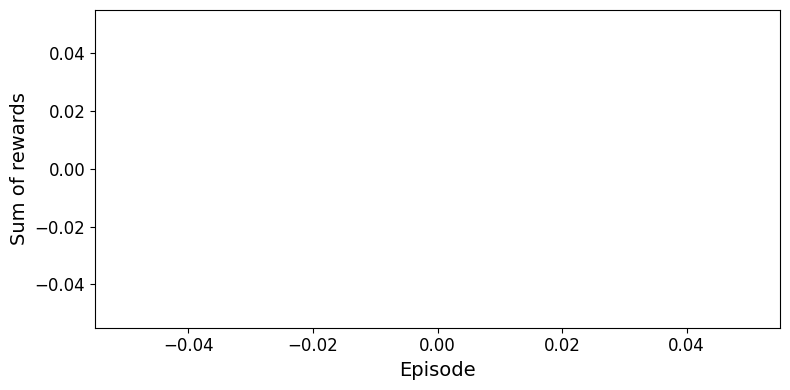

In [ ]:
plt.figure(figsize=(8, 4))
plt.plot(rewards)
plt.xlabel("Episode", fontsize=14)
plt.ylabel("Sum of rewards", fontsize=14)
save_fig("dqn_rewards_plot")
plt.show()

In [ ]:
def render_policy_net(model, n_max_steps=200, seed=42):
    frames = []
    env = gym.make('CartPole-v1',render_mode="rgb_array")
    np.random.seed(seed)
    obs,_ = env.reset(seed=seed)
    for step in range(n_max_steps):
        frames.append(env.render())
        left_proba = model.predict(obs.reshape(1, -1))
        action = int(np.random.rand() > left_proba)
        obs, reward, done, trun, info = env.step(action)
        if done:
            break
    env.close()
    return frames

def update_scene(num, frames, patch):
    patch.set_data(frames[num])
    return patch

def plot_animation(frames, repeat=False, interval=40):
    fig = plt.figure()
    patch = plt.imshow(frames[0])
    plt.axis('off')
    anim = animation.FuncAnimation(
        fig, update_scene, fargs=(frames, patch),
        frames=len(frames), repeat=repeat, interval=interval)
    plt.close()
    return anim

state,_ = env.reset(seed=42)

frames = []

for step in range(200):
    action = epsilon_greedy_policy(state)
    state, reward, done, trun, info = env.step(action)
    if done:
        break
    img = env.render()
    frames.append(img)

plot_animation(frames)